*This code is written by anokas.(https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55/comments) Thanks for sharing!

### Mercedes-Benz Greener Manufacturing
이 대회에 오신 것을 환영합니다! Mercedes-Benz에서 이번에 생산 라인의 자동차가 테스트 단계를 통과하는 데 걸리는 시간을 예측하는 미션을 우리에게 주었습니다. 고전적인 회귀 문제이며 예측 결과는 R2 score로 평가됩니다. 먼저 주어진 데이터들을 살펴 보겠습니다.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('../Dataset'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../Dataset/' + f) / 1000000, 2)) + 'MB')

# File sizes
sample_submission.csv         0.09MB
test.csv                      3.19MB
train.csv                     3.22MB


우리가 최근 익숙했던 것들보다 훨씬 작은 데이터셋입니다. 그리고 이미지 데이터는 없습니다! :) 우리는 하나의 train과 test csv파일을 받았으며, 갖고 놀기에 데이터가 매우 단순함을 알 수 있습니다. 

이제 메모리에 로딩할 시간입니다!

### Training set

In [5]:
df_train = pd.read_csv('../Dataset/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


이것을 통해, 우리의 train 데이터는 단지 4000개의 행으로 구성되어 있지만 내부에는 400개의 익명 처리된 features가 있음을 알 수 있습니다. 이것 뿐만 아니라 ID (행 번호와 같지 않으며, 아마 의미가 있을지도 모릅니다.)와 생산라인에서 걸린 초(秒) 수인 target value가 제공됩니다. 

target 변수의 분포를 살펴 보겠습니다:

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


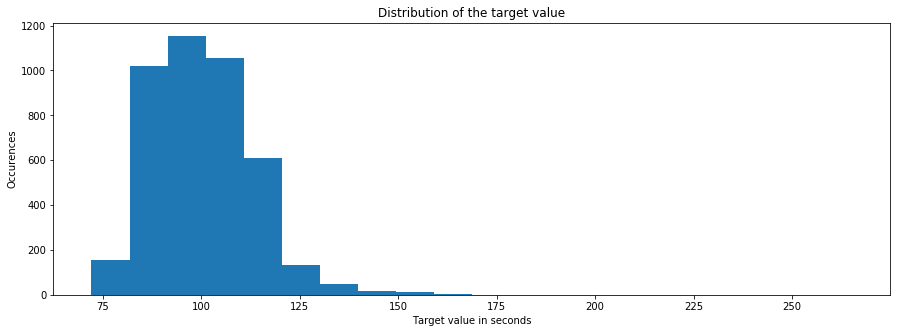

In [6]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

따라서 우리는 위 그래프를 통해 꽤 정규분포와 유사한 분포를 갖고 있으며 100을 기준으로 몰려 있음을 확인할 수 있습니다. 여기서 주목해야 할 것은 딱히 없으며, 모든 값들이 180 밑에 있는 반면 265초 부근에 하나의 특이치가 있습니다. 

ID가 행 ID와 동일하지 않다는 사실을 통해 우리는 train set과 test set가 시계열 데이터와 같은 특별하게 정렬된 데이터를 가지는 데이터셋으로부터 무작위 샘플링되었다고 생각해볼 수 있습니다. 시계열 데이터가 제공된 것이 맞는지 확인해 보기 위해 target value가 시간에 따라 어떻게 변하는지 살펴 보도록 하겠습니다. 

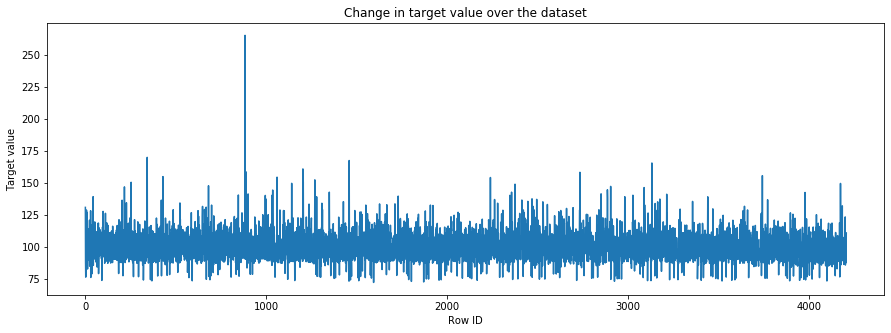

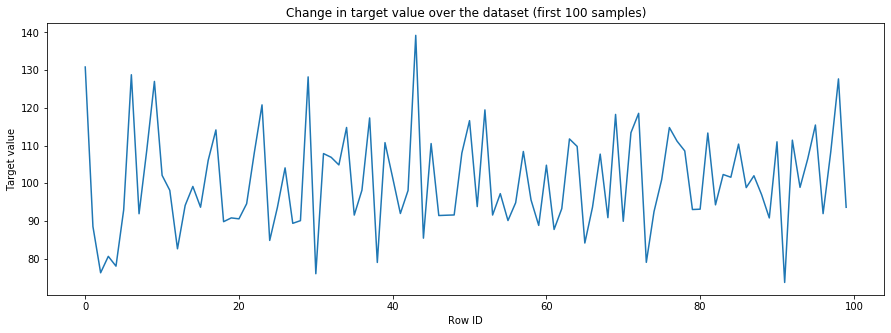

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(y_train)
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_train[:100])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset (first 100 samples)')
print()

한눈에 보기에, 지나치게 의심스러운 부분은 없는 것처럼 보입니다. 나중에 자세히 살펴 보도록 하고, 지금은 feature들을 살펴 보도록 하겠습니다.

### Feature Analysis

In [8]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

우리가 갖고 있는 모든 features를 살펴 보니, 8개의 객체(string 형태와 같은) 변수, 368개의 정수형 변수가 제공되고 있습니다. 우리가 가진 features의 카디널리티는 어떤지 확인해 볼까요? 

<i>(역자주: 카디널리티는 DB에서 한 relation을 구성하는 tuple의 수를 의미한다.)</i>

In [9]:
counts = [[], [], []]
for c in cols:
    typ = df_train[c].dtype
    uniq = len(np.unique(df_train[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'.format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 12 Binary features: 356 Categorical features: 8

Constant features: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Categorical features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


흥미롭게도, 우리는 단지 하나의 값만 가진 12개의 features를 갖고 있습니다. 이것들은 supervised 알고리즘에 대해서는 쓸모가 없으며, 따라서 버려야 합니다. (test set에서 비정상 탐지를 위한 목적으로 사용하지 않는 한)

데이터셋의 나머지 부분들은 많은 이진 변수(binary features)들과 몇 가지 범주형 변수(categorical features)들로 구성됩니다. 

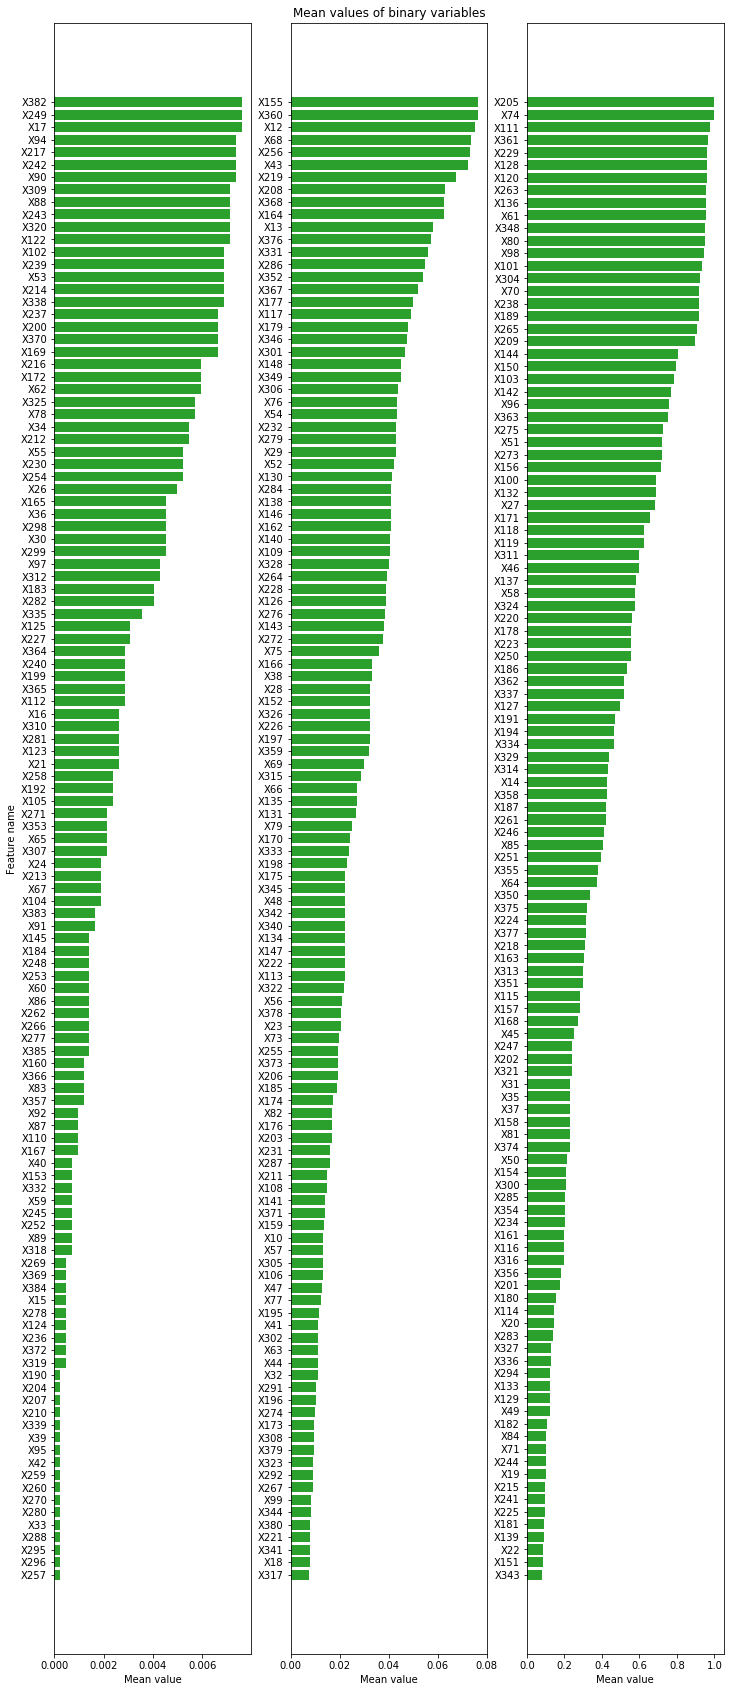

In [10]:
binary_means = [np.mean(df_train[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1, 3, figsize=(12,30))
ax[0].set_ylabel('Feature name')
ax[1].set_title('Mean values of binary variables')
for i in range(3):
    names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
    ax[i].barh(range(len(means)), means, color=pal[2])
    ax[i].set_xlabel('Mean value')
    ax[i].set_yticks(range(len(means)))
    ax[i].set_yticklabels(names, rotation='horizontal')
plt.show()

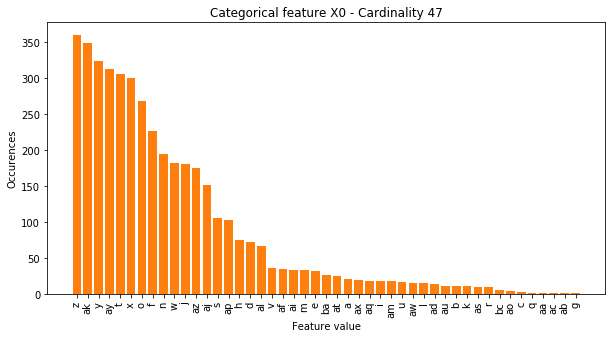

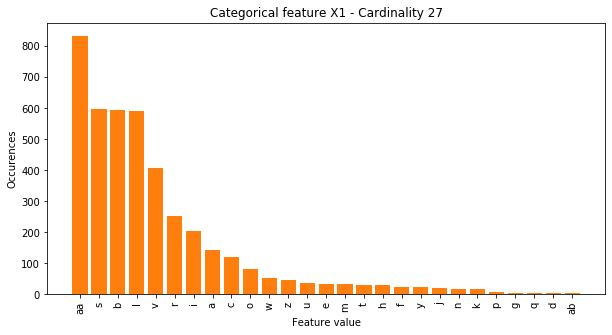

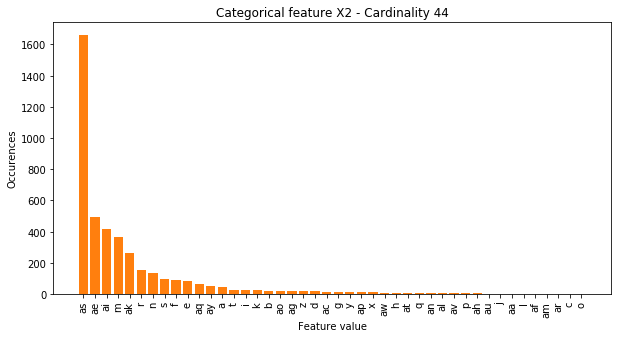

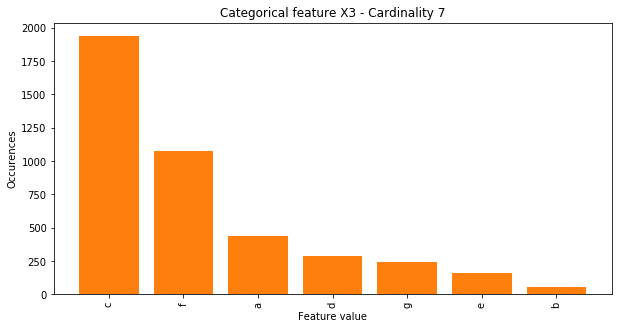

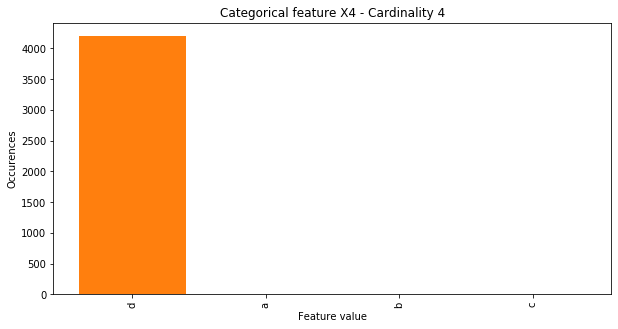

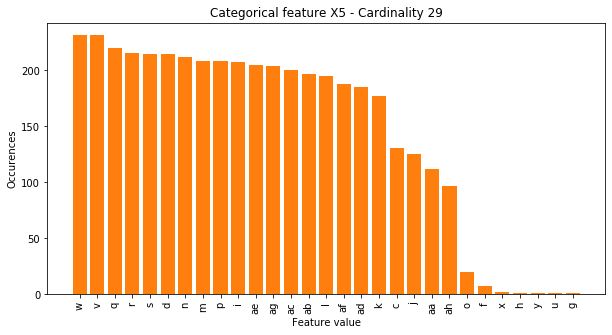

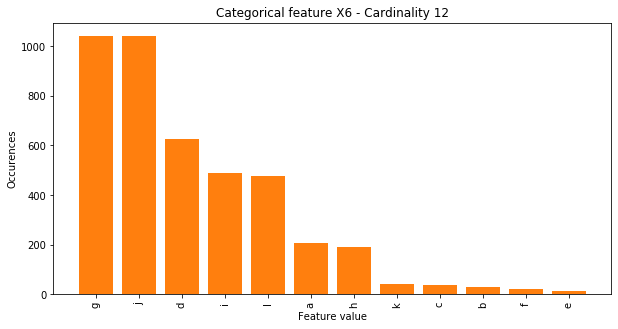

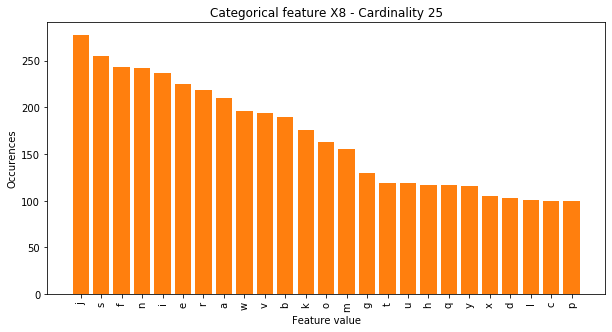

In [11]:
for c in counts[2]:
    value_counts = df_train[c].value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title('Categorical feature {} - Cardinality {}'.format(c, len(np.unique(df_train[c]))))
    plt.xlabel('Feature value')
    plt.ylabel('Occurences')
    plt.bar(range(len(value_counts)), value_counts.values, color=pal[1])
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation='vertical')
    plt.show()

### XGBoost Starter
이제 데이터가 어떻게 구성되어 있는지에 대한 개요를 알았으므로 간단한 모델을 만들 수 있습니다. XGBoost를 사용해 볼 시간입니다!

In [13]:
df_test = pd.read_csv('../Dataset/test.csv')

usable_columns = list(set(df_train.columns) - set(['ID', 'y']))

y_train = df_train['y'].values
id_test = df_test['ID'].values

x_train = df_train[usable_columns]
x_test = df_test[usable_columns]

for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
        x_test.drop(column, axis=1)
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        x_test[column] = x_test[column].apply(mapper)
        
x_train.head()

C:\Users\brsta\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\brsta\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,X335,X44,X83,X236,X245,X35,X378,X327,X341,X220,...,X241,X81,X348,X233,X17,X12,X346,X271,X140,X286
0,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,...,1,0,1,0,1,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [14]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(x_test)

params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[15:48:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:99.1397	valid-rmse:98.2538	train-r2:-58.3426	valid-r2:-67.6247
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.1832	valid-rmse:80.2714	train-r2:-38.7928	valid-r2:-44.804
[20]	train-rmse:66.541	valid-rmse:65.5967	train-r2:-25.7332	valid-r2:-29.5876
[30]	train-rmse:54.6149	valid-rmse:53.6305	train-r2:-17.0092	valid-r2:-19.4459
[40]	train-rmse:44.9172	valid-rmse:43.8842	train-r2:-11.1814	valid-r2:-12.6899
[50]	train-rmse:37.0508	valid-rmse:35.9587	train-r2:-7.28831	valid-r2:-8.19158
[60]	train-rmse:30.6913	valid-rmse:29.5289	train-r2:-4.68723	valid-r2:-5.19837
[70]	train-rmse:25.5745	valid-rmse:24.3342	train-r2:-2.949	valid-r2:-3.20936
[80]	train-rmse:21.4844	valid-rmse:20.1622	train-r2:-1.78687	valid-r

In [15]:
p_test = clf.predict(d_test)

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = p_test
sub.to_csv('xgb.csv', index=False)